# Introduction à l'imagerie numérique 

## Projet : **Texture Generation with Neural Cellular Automata**

### Noms : Seginus Mowlavi et Matthieu Serfaty

In [1]:
!git clone https://github.com/seginusmowlavi/textures-cellular-automata.git

Cloning into 'textures-cellular-automata'...
remote: Enumerating objects: 185, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 185 (delta 9), reused 28 (delta 8), pack-reused 138
Receiving objects: 100% (185/185), 140.51 MiB | 17.92 MiB/s, done.
Resolving deltas: 100% (74/74), done.
Updating files: 100% (41/41), done.


In [4]:
import sys
sys.path.insert(0,'/content/textures-cellular-automata')

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from torchvision.transforms import ToTensor, ToPILImage
from PIL import Image

from model import *
from train import *

import os
import shutil
import pickle

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device = {device}')

device = cuda


# 1 Introduction: description de la méthode

## 1.1 Modèle génératif

Un modèle de génération automatique de texture est présenté dans l'article

[1] [Texture Generation with Neural Cellular Automata](https://arxiv.org/pdf/2105.07299.pdf)

de Mordvintsev, Niklasson, Randazzo datant de 2021. Cet article fait l'observation suivante. Premièrement, les phénomènes de création de textures dans la nature (par exemple le pelage d'un félin) sont souvent modélisés, depuis Turing, par une EDP dite de *réaction-diffusion*
$$ \frac{\partial u}{\partial t} = f(u) + c\Delta u $$
où $u_t(x,y)\in\mathbb{R}^c$ est un vecteur encodant les concentrations de $c$ éléments chimiques à l'instant $t$ au point $(x,y)$ d'une certaine surface. Partant d'un état initial aléatoire (par exemple, chez Turing, une constante à laquelle s'ajoute un faible bruit), l'évolution tend à produire des motifs dans les concentrations. Deuxièmement, une telle équation peut être discrétisée et implémentée informatiquement par un réseau de neurones convolutionnel résiduel et récurrent: partant d'un tenseur initial `u` de dimension `(c,h,w)` (où `(h,w)` sont les dimensions d'une image et `c` est le nombre d'éléments chimiques), on itère la relation `u = u+f(u)` où `f` est un réseau de neurones convolutionnel. À transformation près, on considère que les trois premières composantes  `u` sont les composantes RGB d'une image (c'est-à-dire les concentrations de pigments), et les autres décrivent des concentrations d'éléments chimiques transparents.

On souhaite alors construire `f` telle que si le tenseur `u` est initialement uniformément aléatoire, après plusieurs itérations ses trois premières composantes puissent converger vers un représentant d'une texture RGB prédéfinie.

## 1.2 Méthode d'entraînement

Pour évaluer automatiquement la qualité de `u` en tant que texture, les auteurs se basent sur la littérature de synthèse de textures : si une texture ne peut pas se décrire par les valeurs des pixels d'un représentant quelconque, mais on peut utiliser des descripteurs statistiques sur un représentant. Cette idée s'est concrétisée de plusieurs façons différentes, historiquement par des descritpeurs explicites plus ou moins sophistiqués (par exemple des corrélations spatiales de coefficients d'ondelettes), avec notamment l'article

[2] [Texture Synthesis Using Convolutional Neural Networks](https://arxiv.org/abs/1505.07376)

de Gatys, Ecker, Bethge en 2015. Cet article utilise les sorties des couches cachées du réseau de neurones VGG-16 (créé pour la reconnaissance d'objets) ; de ces sorties (qui sont des tenseurs avec dimensions spatiale, VGG-16 étant convolutionnel), des descripteurs invariants dans l'espace peuvent être extraits en prenant la moyenne de chaque canal, ou en calculant les corrélations entre canaux.

Les méthodes telles que [2] se servent de ces descripteurs pour synthétiser un représentant d'une texture donnée par *optimisation* de ces descripteurs ; chaque synthèse d'un nouveau représentant est alors très coûteuse en calculs. En revanche [1] se sert des descripteurs de [2] pour optimiser les paramètres du réseau `f` : c'est donc un problème *d'apprentissage*, qui une fois résolu permet de générer des représentants de la texture à faible coût calculatoire.

## 1.3 Plan du rapport

Ce rapport présente notre implémentation Pytorch de la méthode de [1] en deux temps : le modèle et l'apprentisssage. L'article [1] omet un certain nombre de détails d'implémentation, et certains des choix qui y sont fait méritent plus de discussion. Nous exposerons nos propres choix au fur et à mesure; ils seront discutés dans une dernière partie de présentation des résultats.


# 2 Architecture du modèle

Le code qui implémente l'architecture du modèle, que nous exposons ici, est contenu dans le fichier model.py.

## 2.1 La classe CAutomaton

Nous avons créé une classe `CAutomaton`, dont les instances appliquent la fonction `u -> u+f(u)`. L'architecture de `CAutomaton` est celle décrite explicitement dans [1], dont est tirée le schéma ci-dessous. Elle s'articule en deux parties.

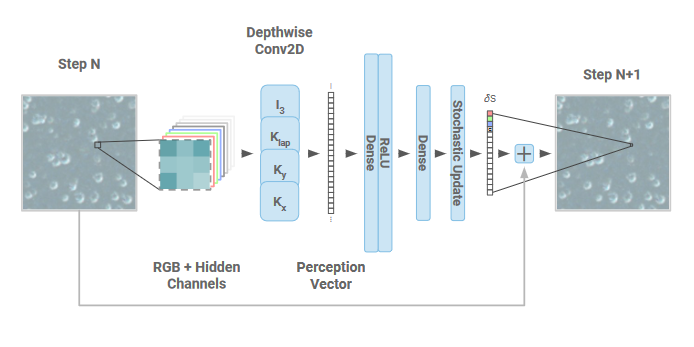

```python
class CAutomaton(nn.Module):

    def __init__(self, num_hidden_states=9,
                       num_hidden_features=96,
                       stochastic=True,
                       bias=False):
        """
        Parameters:
            num_hidden_states   = (int) number of hidden cell-states
            num_hidden_features = (int) number of channels in hidden layer
            stochastic          = (bool) False if all cells update according to
                                  a global clock
            bias                = (bool) bias of second layer of update_rule
        """
        super().__init__()

        # size of the model
        self.num_states = 3+num_hidden_states
        self.num_hidden_features = num_hidden_features

        # layers
        self.perception_filter = nn.Conv2d(self.num_states,
                                           4*self.num_states,
                                           kernel_size=3)
        self.bias = bias
        self.update_rule = nn.Sequential(nn.Conv2d(4*self.num_states,
                                                   self.num_hidden_features,
                                                   kernel_size=1),
                                         nn.ReLU(),
                                         nn.Conv2d(self.num_hidden_features,
                                                   self.num_states,
                                                   kernel_size=1,
                                                   bias=self.bias))
        self.stochastic = stochastic

    def forward(self, x):
        y = nn.functional.pad(x, (1, 1, 1, 1), mode='circular')
        perception = self.perception_filter(y)
        update = self.update_rule(perception)
        if self.stochastic:
            mask = torch.randint(0, 2, x.shape, device=x.device)
            update *= mask
        return x+update

```

## 2.2 Perception

 La première partie, appelée `perception_filter`, joue le rôle d'un extracteur de contours, c'est-à-dire des opérateurs différentiels discrétisés. Cette partie du réseau est initialisée manuellement et n'est pas mise à jour lors de son apprentissage : cela permet de conserver des propriétés de transfert, par exemple pour changer l'orientation ou la grille sans réapprendre les paramètrers du modèle.
 
 Dans [1], les auteurs utilisent des filtres du premier ordre (filtres de Sobel) dans les directions horizontale et verticale ainsi qu'un laplacien discret. 

$$\mathrm{Sobel}_x = \begin{bmatrix} -1 & 0 & 1 \\ -2 & 0 & 2 \\ -1 & 0 & 1 \end{bmatrix}, \mathrm{Sobel}_y = \begin{bmatrix} -1 & -2 & -1 \\ 0 & 0 & 0 \\ 1 & 2 & 1 \end{bmatrix}, \mathrm{Laplacien} = \begin{bmatrix} 1 & 2 & 1 \\ 2 & -12 & 2 \\ 1 & 2 & 1 \end{bmatrix}$$

Par analogie aux équations de réaction-diffusion, **nous considérons aussi des filtres du second ordre uniquement**. Au lieu du seul laplacien, l'utilisation des trois opérateurs du second ordre permet d'introduire de l'anisotropie (qui est sinon perdue avec la suppression des filtres du premier ordre).

La fonction suivante implémente ces deux options.
```python 
def set_perception_kernels(automaton, with_first_order=True):
      """
    Sets the perception filter.
    Since this filter is not learned: requires_grad=False

    Arguments:
        automaton        = (CAutomaton)
        with_first_order = (bool) if True: use identity, 2 Sobels, Laplacian
                           if False: use identity and 3 second-order operators
    """
    n = automaton.num_states
    K = np.zeros((4*n,n,3,3), # shape: (out_ch,in_ch,H,W)
                      dtype=np.float32) # unlike np, torch default is float32

    # identity
    K[np.arange(n),np.arange(n),1,1] = 1

    if with_first_order:
        # Sobel_x
        K[np.arange(n,2*n),np.arange(n),:,:] = np.array([[-1,0,1],
                                                         [-2,0,2],
                                                         [-1,0,1]])
        # Sobel_y
        K[np.arange(2*n,3*n),np.arange(n),:,:] = np.array([[-1,-2,-1],
                                                           [ 0, 0, 0],
                                                           [ 1, 2, 1]])
        # Laplacian
        K[np.arange(3*n,4*n),np.arange(n),:,:] = np.array([[1,  2,1],
                                                           [2,-12,2],
                                                           [1,  2,1]])
    else:
        # d^2/dx^2
        K[np.arange(n,2*n),np.arange(n),:,:] = np.array([[1,-2,1],
                                                         [2,-4,2],
                                                         [1,-2,1]])
        # d^2/dxy
        K[np.arange(2*n,3*n),np.arange(n),:,:] = np.array([[ 1,0,-1],
                                                           [ 0,0, 0],
                                                           [-1,0, 1]])
        # d^2/dy^2
        K[np.arange(3*n,4*n),np.arange(n),:,:] = np.array([[ 1, 2, 1],
                                                           [-2,-4,-2],
                                                           [ 1, 2, 1]])

    automaton.perception_filter.weight = nn.parameter.Parameter(torch.tensor(K))
    automaton.perception_filter.requires_grad_(False)

    return automaton
```

## 2.3 Relation de récurrence

Ce filtre de perception nourrit une fonction `update_rule` dont la sortie (à un masque aléatoire près) est l'incrément résiduel au "tenseur de concentrations chimiques". Cette fonction est un réseau plein à deux couches (par pixel, c'est-à-dire que les couches sont des convolutions à noyaux de taille 1). Notons que d'après l'article [1] (et leur calcul du nombre de paramètres), les deux couches ont un terme de biais ; alors que dans leur implémentation la deuxième couche n'a pas de biais.

Ce sont les paramètres de cette fonction qui sont appris dans la phase d'entraînement. **Il n'est pas précisé dans [1] comment ils sont initialisés, alors que c'est assez important**.

Une initialisation classique (actuellement Pytorch utilise Kaiming par défaut) conduit la fonction à avoir des qui sont trop importantes, au regard du fait que le modèle est itéré sur 32 à 64 itérations. La croissance exponentielle du tenseur `u` conduit en pratique à des valeurs `nan`, ce qui empêche tout calcul par la suite.

Ainsi, nous initialisons la `update_rule` de sorte qu'elle soit nulle en tant que fonction. Pour éviter que les gradients soient nuls (ou qu'ils aient des symétries contraintes), seuls les paramètres de la deuxième couche sont mis à zéro, Pytorch se chargeant de la première couche.

# 3 Apprentissage

C'est dans le fichier train.py que nous définissons comment nous entraînons le modèle.

## 3.1 Fonction de coût I - méthode de calcul

La fonction de coût est calculée sur l'image obtenue après un nombre aléatoire d'itérations du modèle résiduel présenté à la partie précédente ; cette image est comparée à la texture cible. Dans [1], il est uniquement précisé que la comparaison se fait suivant [2], c'est-à-dire en calculant des statistiques spatialement invariantes sur les sorties des couches cachées du modèle multi-échelle VGG-16. Nous avons initialement considéré une variante de [2] qui établit un compromis entre performance et coût calculatoire:
- Seule une couche par échelle de VGG-16 est considérée, ce qui fait cinq au total.
- Sur chaque couche considérée, le nombre de canaux (de 64 à 512) est trop important pour calculer toutes les matrices de corrélation (appelées matrices de Gram), car cela donnerait d'environ $64^2\approx4\times10^3$ à $512^2\approx2\times10^5$ matrices de Gram par couche (ce qui fait beaucoup de calculs, surtout pour la rétropropagation). [2] propose alors de garder uniquement un petit nombre des canaux les plus importants par PCA.

Cependant la PCA, même si elle ne doit être effectuée qu'une fois sur toute la phase d'entraînement, reste trop coûteuse pour nous (notamment en mémoire) car les vecteurs considérés sont de taille $224^2\approx5\times10^4$. **Nous proposons ainsi, à chaque époque d'entraînement, de choisir aléatoirement un petit nombre de paires de canaux à corréler**. Ce calcul est implémenté dans la fonction `compute_gram_features`.

De même que dans l'implémentation de [1] (non précisée dans l'article), **nous considérons aussi l'option de conserver tous les canaux des couches choisies et de simplement en calculer les moyennes individuellement**. Ce calcul est implémenté dans la fonction `compute_mean_features`.

## 3.2 Entraînement sur réservoir

Le principe de base de l'entraînement est le suivant. À chaque époque, un tenseur "d'état" (celui dont les trois premiers canaux représentent notre image) est initialisé aléatoirement et passe à travers un nombre aléatoire d'itérations du modèle résiduel. La fonction de coût est ensuite calculée sur les trois premiers canaux de l'état final, et la rétropropagation (dont l'implémentation Pytorch permet de ne pas se soucier de la récurrence du modèle) donne le gradient. La méthode d'optimisation (Adam) et ses paramètres sont précisés dans [1]. Concrètement, la descente de gradient est effectuée par batchs de 4.

Une subtilité réside dans le fait que le nombre d'itérations du modèle à chaque époque est borné entre 32 et 64; ce qui signifie que si on laisse évoluer un modèle entraîné de la sorte sur plus de 64 itérations, il peut avoir des comportements indésirés (ce qui est en pratique le cas).

L'idée de [1] consiste donc en le maintien d'un réservoir "d'états finaux" (entre guillemets, car on ne peut pas prendre pour état final l'image de la texture cible: un tenseur d'état comprend trois dimensions RGB mais 9 dimensions cachées ! ainsi on stocke dans le réservoir les sorties de chaque époque, qui sont les meilleurs approximations dont on dispose de l'état final). À chaque époque, le batch de quatre états initiaux est tiré parmi les états du réservoir (de sorte que le modèle apprenne à conserver la texture à partir d'elle même, sur les 32 à 64 itérations), avec un des états initiaux écrasé par un tenseur aléatoire (pour que le modèle continue d'apprendre à construire une texture à partir de l'aléatoire).

Ainsi, la phase d'entraînement peut théoriquement voir des états produits par $64n$ itérations du modèle, si $n$ est le nombre d'époques.

Nous implémentons cette routine dans la fonction `train`. Le paramètre `vgg_mode`, qui vaut `gram` ou `'mean'`, permet de choisir entre les deux options présentées au paragraphe précédent.

Notons que notre implémentation de la méthode du réservoir comporte un élément de

[3] [Growing Neural Cellular Automata](https://distill.pub/2020/growing-ca/)

(des mêmes auteurs en 2020) qui est absente de [1] : **parmi les quatre états qui sont piochés du réservoir à chaque époque, celui qui est réinitialisé en un état aléatoire n'est pas choisi aléatoirement, mais comme l'état qui est le plus éloigné de la texture cible** (i.e. celui dont le coût est le plus élevé).

Une autre divergence d'implémentation est la taille du réservoir. La taille choisie en [1], de 1024, nous paraît théoriquement trop élevée : en effet à chaque époque seuls 1/256ème du résevoir est choisi; ce qui veut dire qu'en moyenne, sur tout l'entraînement, un élément du réservoir correspond au plus à $64n/256$ itérations, où $n$ est le nombre d'époques (sans prendre en compte la réinitalisation d'états du réservoir !). Sur $n=8000$ époques, cela veut dire au plus $2000$ itérations vues. Si on veut que ce nombre d'itération soit vu $m$ fois (pour $m$ suffisamment grand pour que le gradient stochastique prenne effet), cela veut dire $2000/m$ itérations vues (donc beaucoup moins qu'un milier). Cela paraît peu pour garantir une évolution stable du modèle. Ainsi, **nous choisissons de prendre un réservoir de taille 32, dans les mêmes proportions que [3]** ($4/32=256/1024$).

## 3.3 Fonction de coût II - terme de régularisation

Nous avons observé que l'implémentation décrite ci-dessus, même en suivant les choix décrits dans [1], ne conduit pas à des résultats exploitables : les tenseurs d'états obtenus par itérations du modèle ne sont pas bornés dans le domaine voulu (même sur les trois premiers canaux uniquement) ! Par conséquent, les images de textures produites sont saturées en noir ou blanc et ne sont pas exploitables.

**Nous pallions ce défaut en ajoutant dans la fonction de coût un terme régularisant**. Ce terme est la somme, en norme L1, des dépassements de domaine de tous les états itérés intermédiaires. Le choix de la norme L1 (plutôt que L2 par exemple) se justifie par le fait que son gradient est constant en norme : un petit dépassement de domaine est aussi mauvais qu'un grand. On ne peut évidemment pas prendre la L0 qui n'est pas différentiable du tout.

Cet ajout permet d'obtenir des résultats satisfaisants.

# 4 En pratique

Dans cette partie, qui se présente comme un notebook interactif, nous testons et analysons nos choix d'implémentation. Elle correspond aux fichiers ``train.ipynb`` et ``test.ipynb`` du répertoire de code.

## 4.1 Chargement de la texture cible

Cette image est utilisée en tant que modèle de texture à reproduire. Nous avons fait des tests avec différentes textures : dans un cas une texture plus simple à reproduire telle que les bulles ci-dessous, dans un autre cas des exemple plus difficile pour tester les limites de la méthode.

Texture simple

<img src="https://www.robots.ox.ac.uk/~vgg/data/dtd/thumbs/bubbly/bubbly_0101.jpg" width=100px>

Texture complexe 

<img src="https://www.robots.ox.ac.uk/~vgg/data/dtd/thumbs/wrinkled/wrinkled_0145.jpg" width=100px>

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:149: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


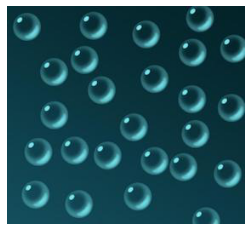

In [7]:
template_name = 'bubbles'

templatePIL = plt.imread(f'/content/textures-cellular-automata/images/{template_name}.jpg')
template = ToTensor()(templatePIL).to(device)

plt.axis('off')
plt.imshow(templatePIL)

## 4.2 Entraînement du modèle

Cette cellule permet simplement d'initialiser notre modèle.

In [8]:
automaton = CAutomaton(bias=True, with_first_order=True)
set_perception_kernels(automaton)
initialize_to_zero(automaton)

automaton.to(device)

print(automaton)

CAutomaton(
  (perception_filter): Conv2d(12, 48, kernel_size=(3, 3), stride=(1, 1))
  (update_rule): Sequential(
    (0): Conv2d(48, 96, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(96, 12, kernel_size=(1, 1), stride=(1, 1))
  )
)


Ici on entraîne notre modèle. Sur Colab en CUDA, 1000 époques prennent environ 5 minutes. Le tout ne dépasse pas les 5Go de mémoire.

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Epoch 0 complete, loss = 31376.146484375
Epoch 100 complete, loss = 28752.421875
Epoch 200 complete, loss = 11480.3994140625
Epoch 300 complete, loss = 10766.73828125
Epoch 400 complete, loss = 9419.876953125
Epoch 500 complete, loss = 8430.1640625
Epoch 600 complete, loss = 7174.4306640625
Epoch 700 complete, loss = 6263.24560546875
Epoch 800 complete, loss = 5955.072265625
Epoch 900 complete, loss = 5299.4921875
Epoch 1000 complete, loss = 5540.7294921875
Epoch 1100 complete, loss = 4279.5986328125
Epoch 1200 complete, loss = 4526.8720703125
Epoch 1300 complete, loss = 3612.906005859375
Epoch 1400 complete, loss = 2590.003173828125
Epoch 1500 complete, loss = 2787.60888671875
Epoch 1600 complete, loss = 2835.4716796875
Epoch 1700 complete, loss = 2537.15234375
Epoch 1800 complete, loss = 3207.280029296875
Epoch 1900 complete, loss = 1973.0931396484375
Epoch 2000 complete, loss = 1743.0738525390625
Epoch 2100 complete, loss = 1747.288330078125
Epoch 2200 complete, loss = 1236.49365234

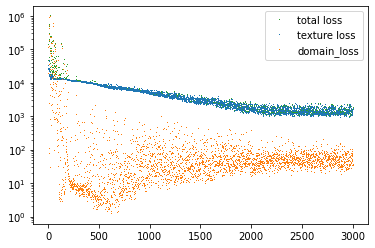

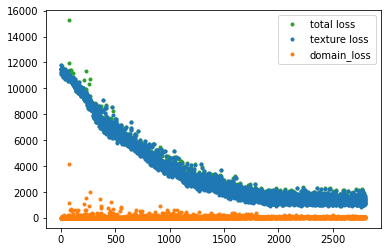

In [9]:
num_epochs = 3000

vgg_mode='mean'

texture_losses, domain_losses, losses = train(automaton, template,
                                              num_epochs=num_epochs,
                                              vgg_mode=vgg_mode)

# plot evolution of loss

plt.semilogy(losses, ',', color='C2', label='total loss')
plt.semilogy(texture_losses, ',', color='C0', label='texture loss')
plt.semilogy(domain_losses, ',', color='C1', label='domain_loss')
plt.legend()
plt.show()

plt.plot(losses[200:], '.', color='C2', label='total loss')
plt.plot(texture_losses[200:], '.', color='C0', label='texture loss')
plt.plot(domain_losses[200:], '.', color='C1', label='domain_loss')
plt.legend()
plt.show()

### <font color='CadetBlue'>**Courbes obtenues sur l'image du chien**</font>
Calculée sur 4000 époques




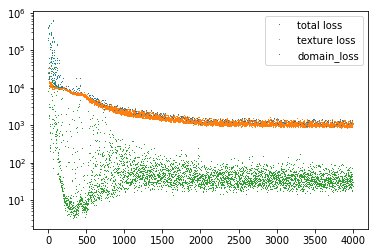

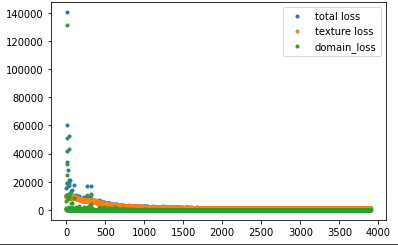

### <font color='CadetBlue'>**Commentaires**</font>

Notons d'abord que la différence marquée de vitesse d'évolution du coût à partir de l'époque 2000 est simplement dûe aux paramètres du "scheduler". La nécessité de dépasser les 3000 époques n'apparaît pas clairement sur les courbes d'évolution du coût. Elle se verra en revanche non seulement sur la capacité du modèle à conserver la texture obtenue, mais aussi (et de manière surprenante) sur le nombre d'itérations nécessaire pour converger vers la texture !

Il est aussi intéressant de remarquer l'évolution de la distribution du terme régularisant (``domain_loss``): initialement il va jusque très haut ($\approx10^5$) mais aussi jusque très bas (et a même tendance à se concentrer sur les basses valeurs, à moins de $10^1$), mais va ensuite se stabiliser vers $10^2$. Cela signifie une compromission pour que la convergence de l'image vers la texture soit plus adéquate.

Cela soulève ainsi la question de la pondération de ce terme régularisant; elle ne s'est pas trop posée, car le comportement observé ici nous paraît tout à fait adéquat. En effet, le dépassement de domaine de $10^2$ (comme constaté sur la fin de l'entraînement) est une somme sur 32 à 64 itérations, sur des images de $\approx5*10^4$ pixels; ce qui signifie que le dépassement moyen par pixel est au plus de $10^{-4}$, ce qui ne se voit pas sur 8 bits. Ainsi le terme régularisant a rempli son objectif, et ce faisant a laissé la main au terme de distance à la texture cible: exactement ce qu'il faut.

## 4.3 Test des modèles entraînés

Le bloc ci-dessous permet d'entraîner le modèle sur le nombre d'itérations voulu, pour produire une image de dimensions voulues.

Même si la procédure d'entraînement est établie pour des images de dimensions `(128, 128)`, il n'y a pas de raison que le modèle ne fonctionne pas sur des images de dimensions différentes. En effet, tout est local dans la méthode, de l'architecture (convolutionnelle de petit champ récepteur) à l'entraînement (fonctions de coûts spatialement invariantes).

In [ ]:
shape = (128, 128)

from torchvision.utils import save_image

if os.path.exists('outputs'):
    shutil.rmtree('outputs')
    os.mkdir('outputs')
else:
    os.mkdir('outputs')

test_iters = 1000

# iterate automaton from random initial state
with torch.inference_mode():
    states = torch.rand((1, automaton.num_states, *shape), device=device)
    for step in range(test_iters):
        states = automaton(states)
        img = states[:, :3, :, :]

        save_image(img[0], f'outputs/epoch_{step:05}.png')

On peut ensuite produire un gif animé du résultat.

In [ ]:
# Make a gif animation
def make_gif(test_iters, name):
    frames = [Image.open(f'outputs/epoch_{iter:05}.png') for iter in range(test_iters)]
    frame_one = frames[0]
    frame_one.save(f"gifs/{name}_evolution.gif", format="GIF", append_images=frames,
               save_all=True, duration=10, loop=0)

make_gif(test_iters, name)

### <font color='CadetBlue'>**Résultats**</font>

Les deux images 128x128 ci-dessous sont correspondent à un résultat stable du modèle, à partir d'une centaine  d'itérations (et stable jusqu'à au moins 1000 itérations), pour les deux exemples ci-dessus.

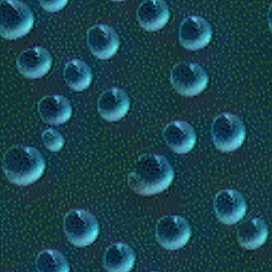

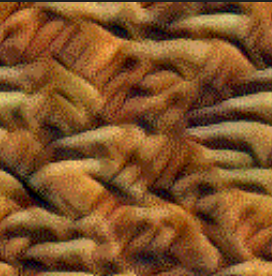

Notons les pixels de bruits, qui ne sont pas présents chez [1]. De manière inattendue, la production d'images 256x256 sur les mêmes modèles ne présentent plus ce bruit, mais introduisent des artefacts de ringing (notamment sous les bulles).

## 4.4 Retour sur les filtres de perception

Faisons une dernière remarque sur les filtres de perception. Pour nos modèles, nous avons constaté que la suppression des filtres d'ordre 1 produit de moins bons résultats, surtout sur les bulles. Ce n'est pas forcément surprenant, au regard du fait que la motivation provient de la réaction-diffusion, qui dans la nature ne produit pas forcément tous les types de textures.

Cependant, nous notons que nos textures sont toutes *statiques*, à l'inverse des résultats de [1] où, au fil des itérations et après stabilisation de la texture, on observe un *mouvement de translation rectiligne uniforme*. C'est ce mouvement qui a motivé l'expérience de supprimer les filtres d'ordre 1. En effet, considérons un modèle d'EDP avec un canal $u_t(x,y)\in\mathbb{R}$ (qui n'a pas d'intérêt pour la réaction-diffusion, mais permet d'intuiter de probables phénomènes en jeu). Si l'EDP est linéaire avec uniquement des termes d'ordre $1$
$$ \frac{\partial u}{\partial t} = a\frac{\partial u}{\partial x} + b\frac{\partial u}{\partial y} \,,$$
on reconnaît l'équation d'onde qui impose que le gradient tridimensionnel est dans une seule direction: les solutions sont donc exactement de la forme $u_t(x,y)=f(x+ta,y+tb)$. Cela se généralise faiblement : en ajoutant un opérateur différentiel spatial $D$, l'équation
$$ \frac{\partial u}{\partial t} = a\frac{\partial u}{\partial x} + b\frac{\partial u}{\partial y} + Du$$
admet des solutions de la forme $u_t(x,y)=f(x+ta,y+tb)$ où $f$ est solution de $Df=0$. On a alors là un mouvement de translation rectiligne uniforme sur une image statique.

Pour étudier l'importance effective des filtres d'ordre 1 dans un modèle entraîné, il suffit d'appliquer une itération sur un tenseur de gradient constant : une telle image donne une réponse spécifique aux filtres d'ordre 1 et une réponse nulle à ceux d'ordre supérieur. Cela s'implémente par exemple sur le code suivant, qui teste différentes orientations aléatoires du gradient sur les différents canaux du tenseur d'état.

In [ ]:
n = 256

x = torch.linspace(0, 1, n)[None, None, :, None].expand((1, 12, n, n))
y = torch.linspace(0, 1, n)[None, None, None, :].expand((1, 12, n, n))

for i in range(50):
    wx, wy, p = torch.rand((12)), torch.rand((12)), torch.rand((12))
    wx = (wx/wx.sum())[None, :, None, None].expand((1, 12, n, n))
    wy = (wy/wy.sum())[None, :, None, None].expand((1, 12, n, n))
    p = p[None, :, None, None].expand((1, 12, n, n))
    states = p*wx*x+(1-p)*wy*y
    #print((automaton(states)-states).abs().max().item())
    print((automaton(states)-states).abs().mean().item())

Sur notre modèle, on constate effectivement que l'itération résiduelle est très faible sur ces tenseurs de gradient constant: la valeur moyenne d'un pixel en valeur absolue est de l'ordre de $5\times10^{-3}$ (ce qui vaut une unité sur 8 bits), et la valeur maximale est d'environ $10^{-1}$.

Cela valide le résultat constaté que nos textures sont statiques (ce résultat est au passage frappant, étant donné qu'aucun mécanisme de la méthode ne le force). Il serait intéressant d'obtenir les poids des modèles entraînés par [1] pour mener la même étude.